<a href="https://githubtocolab.com/Astolfo2332/HyM_prediction/blob/main/0.3_Modelos_iniciales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## Descarga de datos y su concatenación

In [ ]:
!wget https://udeaeduco-my.sharepoint.com/:x:/g/personal/miguel_lopez4_udea_edu_co/EVHE94KrK6dDlEPHLQNgZcsBEPXo0nDZlyaY4-jJyWAlnA?e=Lnfq0g

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve,train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.metrics import mean_squared_error,average_precision_score
import seaborn as sns

In [147]:
dataset=pd.read_csv("data_set.csv")

In [148]:
dataset

,customer_id,article_id,price,FN,Active,club_member_status,fashion_news_frequency,age,product_type_name,colour_group_name,index_group_name,section_name,rebuy
0,286,108775015,0.008458,0,0,0,1,48,119,1,2,43,0
1,286,108775015,0.008458,0,0,0,1,48,119,1,2,43,1
2,286,108775015,0.008458,0,0,0,1,48,119,1,2,43,1
3,518,108775015,0.006763,1,1,0,3,50,119,1,2,43,1
4,672,108775015,0.008458,1,1,0,3,28,119,1,2,43,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15894158,741829,956217002,0.059305,1,1,0,3,60,31,1,2,53,1
15894159,924005,956217002,0.059305,0,0,0,1,31,31,1,2,53,1
15894160,974829,956217002,0.059305,1,1,0,3,53,31,1,2,53,1
15894161,1005272,956217002,0.059305,0,0,0,1,57,31,1,2,53,1


## 0.1 Ajuste del dataset

Debido a la gran cantidad de datos vamos a recortarlos para tener una mejor cantidad para no aumentar el gasto computacional

In [149]:
dataset=pd.concat([dataset[dataset["rebuy"]==0],dataset[dataset["rebuy"]==1][:100000]])
dataset

,customer_id,article_id,price,FN,Active,club_member_status,fashion_news_frequency,age,product_type_name,colour_group_name,index_group_name,section_name,rebuy
0,286,108775015,0.008458,0,0,0,1,48,119,1,2,43,0
5165,294,108775044,0.008322,1,1,0,3,42,119,47,2,43,0
8645,8803,108775051,0.004051,1,1,0,3,22,119,29,2,43,0
8743,11999,110065001,0.025407,1,1,0,3,27,15,1,2,46,0
9234,9219,110065002,0.016932,1,1,0,3,53,15,47,2,46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100112,46991,179950001,0.021780,1,1,0,3,22,7,1,2,41,1
100113,47312,179950001,0.025407,0,0,0,1,20,7,1,2,41,1
100114,48950,179950001,0.022864,1,1,0,3,49,7,1,2,41,1
100115,49517,179950001,0.025407,1,1,0,3,24,7,1,2,41,1


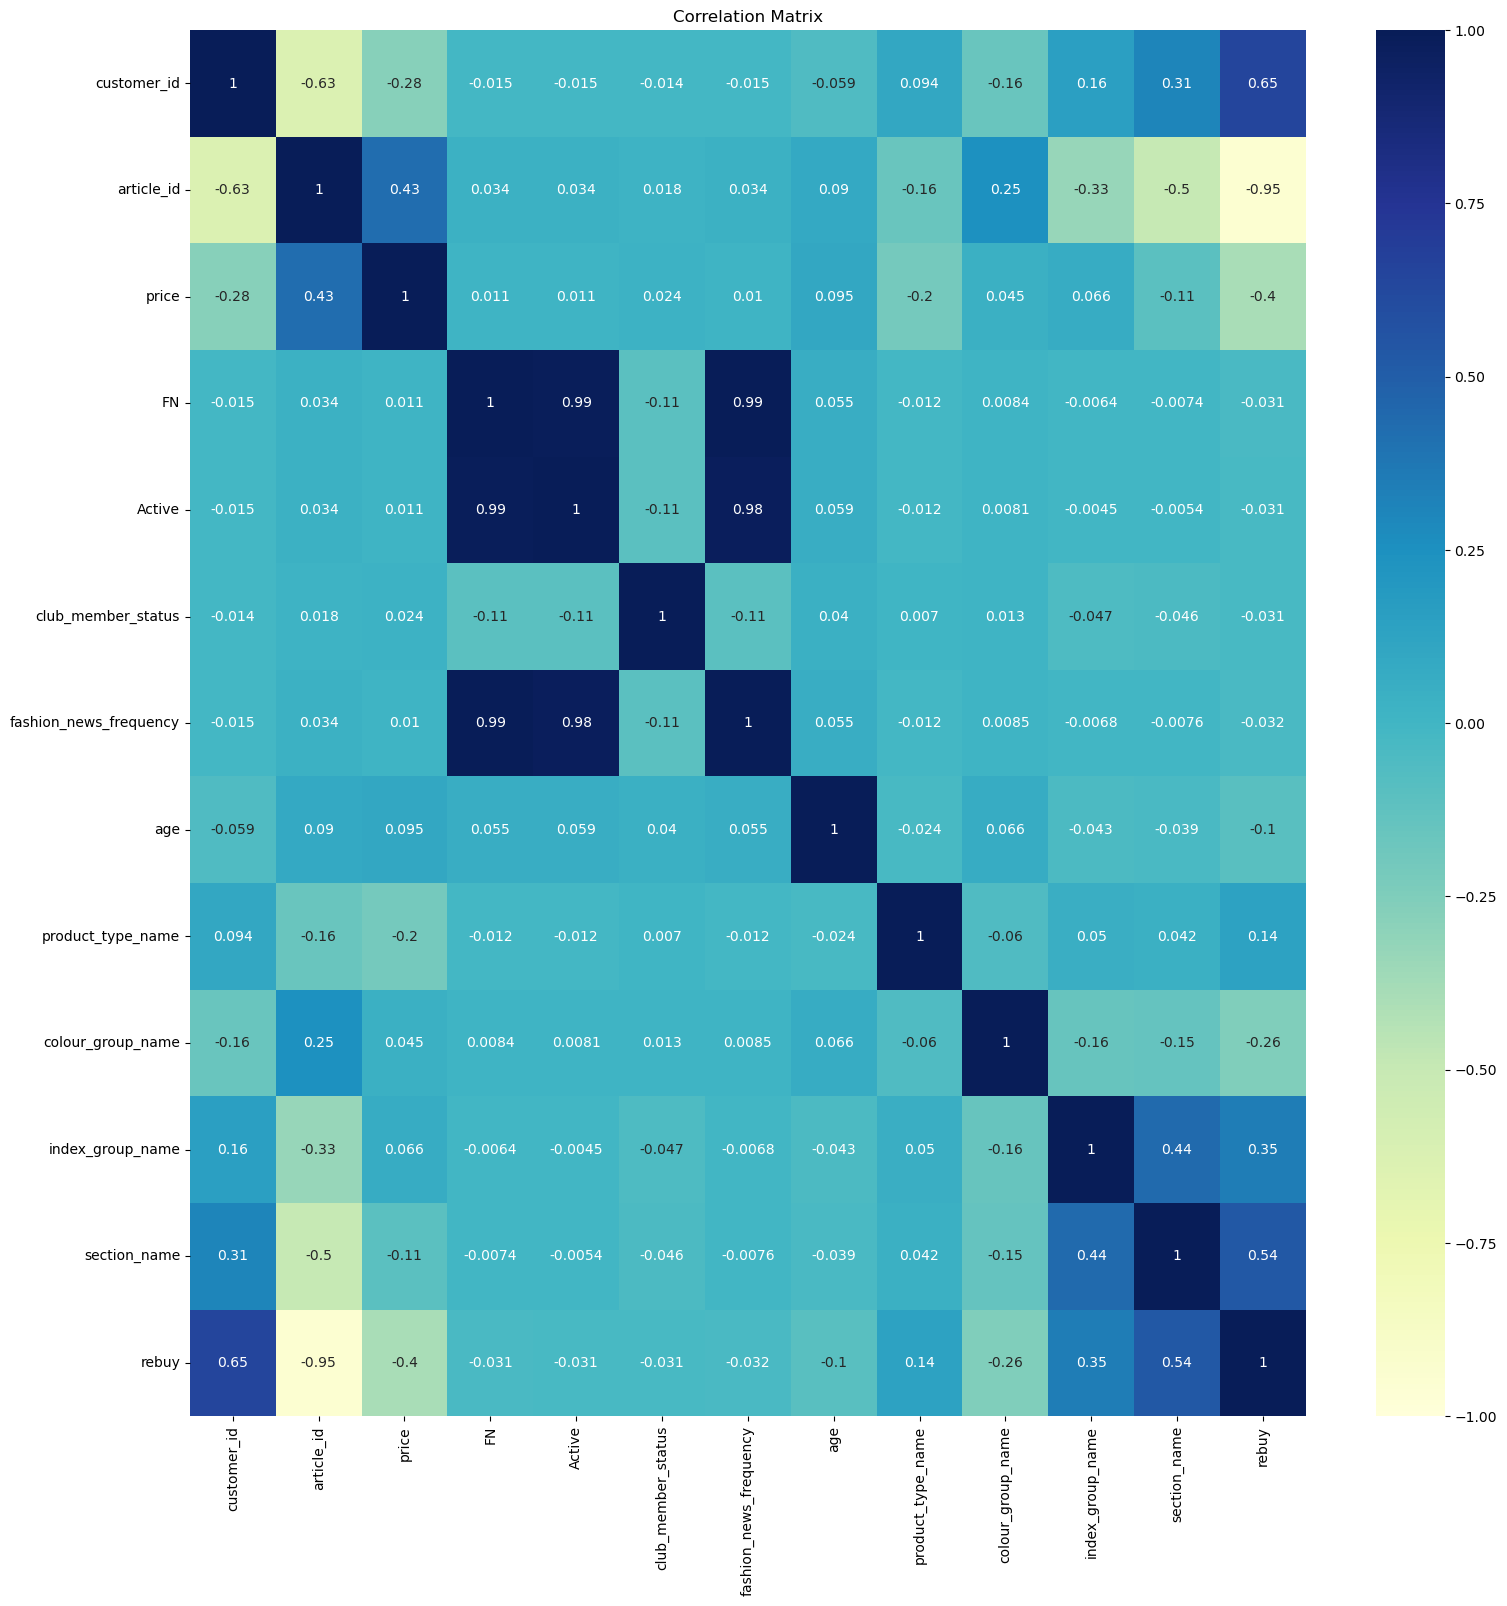

In [150]:
corr_matrix = dataset.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [151]:
target_corr_df = pd.DataFrame(corr_matrix["rebuy"].sort_values(ascending=False))
target_corr_df 

,rebuy
rebuy,1.000000
customer_id,0.646676
section_name,0.539030
index_group_name,0.347487
product_type_name,0.136009
club_member_status,-0.030942
Active,-0.030952
FN,-0.031374
fashion_news_frequency,-0.031603
age,-0.100182


# 1. Curvas de aprendizaje

Para conocer el valor de datos necesarios para entrenar un buen modelo, o ver como responden los diferentes algoritmos a la cantidad de datos de este problema, primero se realizaran curvas para observar su comportamiento y así evaluar si se necesita agregar más datos

In [152]:
x=dataset.drop(["rebuy"],axis=1)
y=dataset["rebuy"].values

In [153]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))
    
    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("MSE"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

In [154]:
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(200560, 12) (200560,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(140392, 12) (60168, 12)


In [155]:
Des_tree1 = DecisionTreeRegressor(max_depth=15)
train_sizes, train_scores, valid_scores = learning_curve(Des_tree1, Xtv, ytv, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))

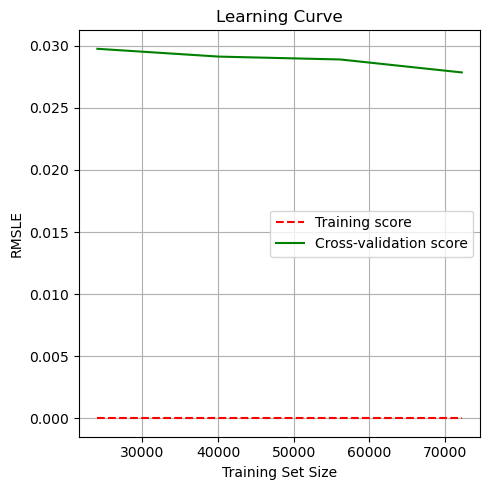

In [156]:
train_scores = np.abs(train_scores)
valid_scores = np.abs(valid_scores)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.subplots(1, figsize=(5,5))
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



plt.grid()
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSLE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [157]:
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 9)

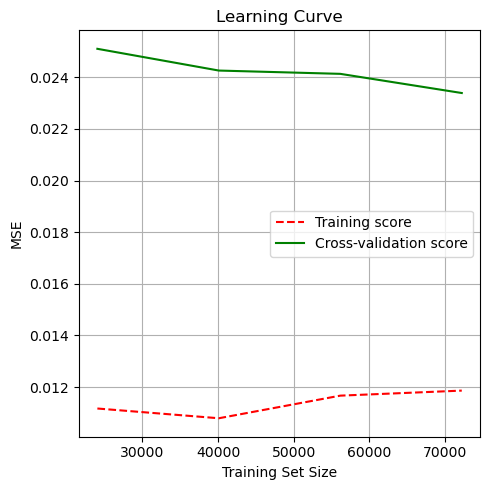

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [158]:
lc_plot(Rdm_forest,Xtv,ytv)

In [159]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
X_t1 = pca.fit_transform(x)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
Rdm_forest = RandomForestRegressor(n_estimators = 15,max_depth = 9)

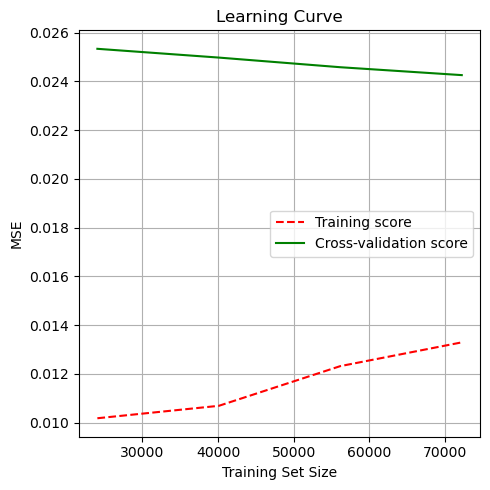

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [160]:
lc_plot(Rdm_forest,Xtv,ytv)

In [161]:
from sklearn.decomposition import NMF
nmf = NMF(n_components = 3)
X_t2 = nmf.fit_transform(x)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
Des_tree = DecisionTreeRegressor(max_depth=15)

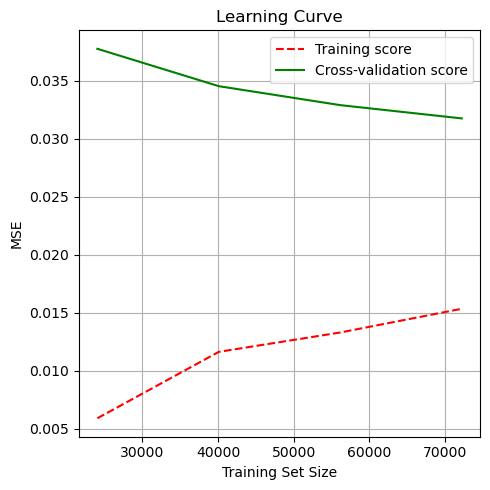

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [162]:
lc_plot(Des_tree,Xtv,ytv)

En los casos anteriores se puede observar que los modelos obtienen mejores resultados dependiendo de la cantidad de datos, pero esto indicaría tener que adicionar muchos datos lo cual resultaría en un costo computacional elevado, para ello entonces se buscara un punto de equilibrio con la sección de código 0.1

# 2. Métodos supervisados

Métrica

In [163]:
def report_cv_score(z):
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSE Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSE Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

Se usara en este caso el MSE como métrica principal

In [164]:
from sklearn.model_selection import train_test_split

test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(200560, 12) (200560,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(140392, 12) (60168, 12)


In [165]:
estimator1 = LinearRegression()
estimator2 = DecisionTreeRegressor(max_depth=5)
estimator3 = RandomForestRegressor(n_estimators = 2,max_depth = 5)

In [166]:
#Selección de modelos

zscores = []
estimators = [estimator1, estimator2, estimator3]
for estimator in estimators:
    print("---------")
    z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=10, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(np.sqrt(z['test_score']*(-1))))
best = np.argmin(zscores)
print ("Seleccionado: ", best)
best_estimator = estimators[best]
print ("\n Mejor modelo: ")
print (best_estimator)

---------
RMSE Test:  0.14619 (± 0.00056080 )
RMSE Train:  0.14658 (± 0.00042025 )
---------
RMSE Test:  0.02362 (± 0.00154237 )
RMSE Train:  0.01935 (± 0.00087878 )
---------
RMSE Test:  0.02236 (± 0.00118348 )
RMSE Train:  0.02019 (± 0.00094328 )
Seleccionado:  2

 Mejor modelo: 
RandomForestRegressor(max_depth=5, n_estimators=2)


In [167]:
from sklearn.model_selection import GridSearchCV

In [168]:
#Esta celda puede tomar un tiempo considerable en su ejecución
parametros = {'max_depth': [2,5,8,12,15,60,100,200,250]}


decission_tree = GridSearchCV(estimator = estimator2,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(Xtv, ytv)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=DecisionTreeRegressor(max_depth=5), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 12, 15, 60, 100, 200, 250]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [169]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Mejor estimador Decision Tree:  DecisionTreeRegressor(max_depth=2)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 2}


In [170]:
Des_tree = DecisionTreeRegressor(max_depth= decission_tree.best_params_["max_depth"])
Des_tree.fit(Xtv, ytv)

DecisionTreeRegressor(max_depth=2)

In [171]:
print('RMS del Decision Tree en entrenamiento: ',"{:.5f}".format(mean_squared_error((ytv) , (Des_tree.predict(Xtv)))))
print('RMS del Decision Tree seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Des_tree.predict(Xts))))

RMS del Decision Tree en entrenamiento:  0.00050
RMS del Decision Tree seleccionado:  0.00064


In [172]:
#Esta celda toma un tiempo considerable en completarse
parametros = { 'n_estimators': [5,10,15,20,30],
              'max_depth':[5,7,9,15,20,30]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9, 15, 20, 30],
                         'n_estimators': [5, 10, 15, 20, 30]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [173]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=5, n_estimators=20)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 5, 'n_estimators': 20}


In [174]:
Rdm_forest = RandomForestRegressor(n_estimators = forest_reg.best_params_["n_estimators"],max_depth = forest_reg.best_params_["max_depth"])
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=5, n_estimators=20)

In [175]:
print('Mean square del Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error((ytv) , (Rdm_forest.predict(Xtv)))))
print('Mean square del Random Forest seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts))))

Mean square del Random Forest en entrenamiento:  0.00038
Mean square del Random Forest seleccionado:  0.00053


## PCA

In [176]:
from sklearn.decomposition import PCA
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 9)
for i in components:
    pca = PCA(n_components = i)
    X_t = pca.fit_transform(x)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Rdm_forest.fit(Xtv, ytv)
    perf.append(mean_squared_error(yts , Rdm_forest.predict(Xts)))
    print('Mean square del modelo con ', i ,'elementos: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts))))
    print('------------')

print('Mejor Mean Square: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')
    

(140392, 1) (60168, 1)
Mean square del modelo con  1 elementos:  0.00064
------------
(140392, 3) (60168, 3)
Mean square del modelo con  3 elementos:  0.00053
------------
(140392, 5) (60168, 5)
Mean square del modelo con  5 elementos:  0.00057
------------
(140392, 7) (60168, 7)
Mean square del modelo con  7 elementos:  0.00066
------------
(140392, 9) (60168, 9)
Mean square del modelo con  9 elementos:  0.00076
------------
Mejor Mean Square:  0.00053   ; obtenido con  3  componentes para PCA


In [177]:
#MEJOR PCA
pca = PCA(n_components = components[np.argmin(perf)])
X_t1 = pca.fit_transform(x)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(140392, 3) (60168, 3)


In [178]:
#Nota: Correr esta celda toma un tiempo considerable
parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [179]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=5, n_estimators=15)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 5, 'n_estimators': 15}


In [180]:
#Mejor random forest para el PCA obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
Rdm_forest = RandomForestRegressor(n_estimators = forest_reg.best_params_["n_estimators"],max_depth = forest_reg.best_params_["max_depth"])
Rdm_forest.fit(Xtv, ytv)

(140392, 3) (60168, 3)


RandomForestRegressor(max_depth=5, n_estimators=15)

In [181]:
#Desempeño del modelo Random Forest seleccionado

print('Mean square Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error((ytv) , (Rdm_forest.predict(Xtv)))))
print('Mean square del Random Forest seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts))))

Mean square Random Forest en entrenamiento:  0.00050
Mean square del Random Forest seleccionado:  0.00053


# NMF

In [182]:
from sklearn.decomposition import NMF
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Des_tree = DecisionTreeRegressor(max_depth=15)
for i in components:
    nmf = NMF(n_components = i)
    X_t = nmf.fit_transform(x)
    
    #Partición de datos
    #Xtv, ytv son los datos que se usan para entrenar el modelo
    #Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Des_tree.fit(Xtv, ytv)
    perf.append(mean_squared_error(yts , Des_tree.predict(Xts)))
    print('RMSLE del modelo con ', i ,'elementos: ',"{:.5f}".format(mean_squared_error(yts , Des_tree.predict(Xts))))
    print('------------')

print('Mejor RMSLE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


(140392, 1) (60168, 1)
RMSLE del modelo con  1 elementos:  0.00066
------------
(140392, 3) (60168, 3)
RMSLE del modelo con  3 elementos:  0.00086
------------
(140392, 5) (60168, 5)
RMSLE del modelo con  5 elementos:  0.00106
------------
(140392, 7) (60168, 7)
RMSLE del modelo con  7 elementos:  0.00088
------------
(140392, 9) (60168, 9)
RMSLE del modelo con  9 elementos:  0.00070
------------
Mejor RMSLE:  0.00066   ; obtenido con  1  componentes para PCA


In [183]:
#MEJOR NMF
nmf = NMF(n_components = components[np.argmin(perf)])
X_t2 = nmf.fit_transform(x)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(140392, 1) (60168, 1)


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [184]:
#Nota: esta celda requiere de gran tiempo para completarse
parametros = {'max_depth': [2,5,8,12,15]}


decission_tree = GridSearchCV(estimator = estimator2,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(Xtv, ytv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=DecisionTreeRegressor(max_depth=5), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 12, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [185]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Mejor estimador Decision Tree:  DecisionTreeRegressor(max_depth=2)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 2}


In [186]:
#Mejor Decision Tree para el NMF obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
Des_tree = DecisionTreeRegressor(max_depth=decission_tree.best_params_["max_depth"])
Des_tree.fit(Xtv, ytv)

(140392, 1) (60168, 1)


DecisionTreeRegressor(max_depth=2)

In [187]:
print('Map_12 del Decision Tree en entrenamiento: ',"{:.5f}".format(mean_squared_error((ytv) , (Des_tree.predict(Xtv)))))
print('Map_12 del Decision Tree seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Des_tree.predict(Xts))))

Map_12 del Decision Tree en entrenamiento:  0.00056
Map_12 del Decision Tree seleccionado:  0.00066
